<a href="https://colab.research.google.com/github/oksuzian/Mu2eANL/blob/master/Wideband/WidebandAna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob

%pip -q install uproot > /dev/null
%pip -q install awkward > /dev/null
%pip install lmfit > /dev/null
import math

import awkward as ak
import uproot
import os

pd.options.display.max_columns = None

In [2]:
plt.style.use('seaborn-whitegrid')
plt.rcParams["grid.linestyle"] = (5,15)
plt.rcParams["grid.linewidth"] = 0.7
plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams.update({'font.size': 22})

In [3]:
try:
    from google.colab import drive
    drive.mount("/content/drive")
    main_path = '/content/drive/MyDrive/'
except:
    main_path = ''
sys.path.append(main_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
if False:
  !apt-get -qq install krb5-user > /dev/null
  !wget https://authentication.fnal.gov/krb5conf/Linux/krb5.conf > /dev/null
  os.environ['KRB5_CONFIG'] = 'krb5.conf'
  !kinit oksuzian@FNAL.GOV
  !scp -o StrictHostKeyChecking=no -o GSSAPIAuthentication=yes -o GSSAPIDelegateCredentials=yes oksuzian@mu2egpvm03.fnal.gov:/pnfs/mu2e/scratch/outstage/ehrlich/wideband14/crvreco/rec.mu2e.CRV_wideband_cosmics.crvaging-005*.root drive/MyDrive/Wideband/

In [5]:
fileList = glob.glob('drive/MyDrive/Wideband/*005_v2*')
df = pd.DataFrame()
for root_file in fileList[0:2]:
  print(root_file)
  tree = uproot.open(root_file+":run")
  df_ = tree.arrays(filter_name=['PEs', 'timeSinceSpill', 'spillNumber', 'eventNumber'],library="pd")
  df = df.append(df_)

df.columns = df.columns.str.replace(r'\[', '_')
df.columns = df.columns.str.replace(r'\]', '')
df = df.reset_index()

drive/MyDrive/Wideband/rec.mu2e.CRV_wideband_cosmics.crvaging-005_v2.001137_000.root


/usr/local/lib/python3.7/dist-packages/uproot/interpretation/library.py:805: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  out[name] = series[name]


drive/MyDrive/Wideband/rec.mu2e.CRV_wideband_cosmics.crvaging-005_v2.001138_000.root


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  # Remove the CWD from sys.path while we load stuff.


In [6]:
PEs_arr=tree.arrays(filter_name=['PEs', 'timeSinceSpill', 'spillNumber', 'eventNumber'])
hit_mask = PEs_arr['PEs'] > 0

Text(0.5, 0, 'PEs')

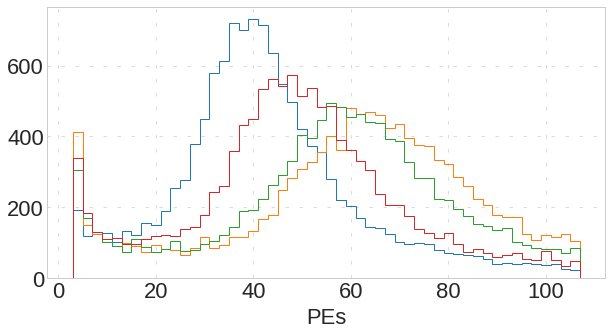

In [7]:
bins=np.arange(3,109,2)
for feb in range(0,4):
  plt.hist(df['PEs_%d_20'%feb], histtype='step', bins=bins);

plt.xlabel('PEs')

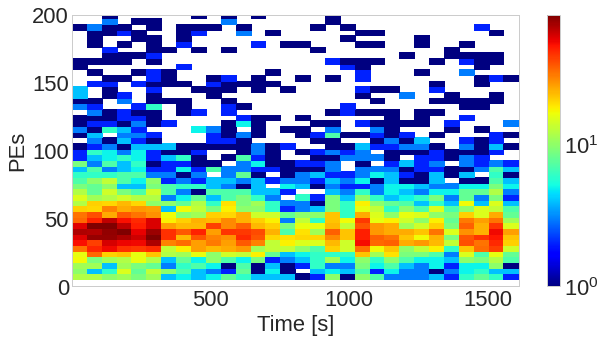

In [8]:
df_cut = df.loc[df['PEs_0_0']>5]
plt.hist2d(df_cut['spillNumber'] + df_cut['timeSinceSpill_0_0']/1e9, df_cut['PEs_0_0'], bins=(30,200), norm=matplotlib.colors.LogNorm(), cmap=plt.cm.jet);
plt.ylim(0,200)
plt.colorbar()
plt.ylabel('PEs')
plt.xlabel('Time [s]');

In [9]:
feb_map = []
feb_map.append((0, 2, 3)) # feb_map[0] is connected to (module_number=0, layer1=2, layer2=3)
feb_map.append((1, 0, 1)) # feb_map[1] is connected to (module_number=1, layer1=0, layer2=1)
feb_map.append((1, 2, 3))
feb_map.append((2, 0, 1))
feb_map.append((3, 2, 3))
MAX_FEB = len(feb_map) # Max number of FEB in the configuration

In [10]:
PADS_BETWEEN_MODULES = 10.16 # insulation pads between modules in cm
MAX_PE = 75 # Max PE value to display
LAYER_OFFSET = 4.2 # cm
COUNTER_WIDTH = 5.0 # cm
COUNTER_HEIGHT = 2.0 # cm

gapBetweenLayers =  0.9525  # cm - taken from Offline/Mu2eG4/geom/crv_counters_v08.txt
aluminumSheetThickness = 0.3175 # cm
strongBackThickness = 1.27    # cm

MODULE_HEIGHT = 4*COUNTER_HEIGHT+3*gapBetweenLayers+aluminumSheetThickness+strongBackThickness

def getXY(feb, chan):

      layer_list = (feb_map[feb][1], feb_map[feb][2]) # Local layers that FEB is connected with a module 
      module_num = feb_map[feb][0] # Module number FEB is connected to

      local_layer = layer_list[chan//32] # Layer within a module (0,1,2,3)
      global_layer = local_layer + module_num*4 # Layer within a stack of module (0,1,2,3,4,5...)

      y = -global_layer*(COUNTER_HEIGHT+gapBetweenLayers) \
          -module_num*(PADS_BETWEEN_MODULES+strongBackThickness-gapBetweenLayers+aluminumSheetThickness) \

      x = COUNTER_WIDTH/2*(chan%32)+LAYER_OFFSET*local_layer+COUNTER_WIDTH/4

      return (x, y)


In [11]:
for feb in range(MAX_FEB):
  chanList = list()
  for x in range(0, 32):
    if (feb==0 or feb==3 or feb==4) and (x<2  or x==14 or x==15 or x==16 or x==17 or x>=28):
      continue
    chanList.append('PEs_%d_%d'%(feb,x))
  df['SumPEs_%d_%d'%(feb,x//32)] = df[chanList].sum(axis=1)

  chanList = list()
  for x in range(32, 64):
    if (feb==0 or feb==3 or feb==4) and (x<34 or x==46 or x==47 or x==48 or x==49 or x>=60):
      continue
    chanList.append('PEs_%d_%d'%(feb,x))
  df['SumPEs_%d_%d'%(feb,x//32)] = df[chanList].sum(axis=1)

In [12]:
trigger_cols = ['SumPEs_0_0','SumPEs_0_1','SumPEs_3_0', 'SumPEs_3_1', 'SumPEs_4_0', 'SumPEs_4_1']
testing_cols = ['SumPEs_1_0','SumPEs_1_1','SumPEs_2_0', 'SumPEs_2_1']
df['trig_nhits'] = df[trigger_cols].gt(20).sum(axis=1)
df['test_nhits'] = df[testing_cols].gt(10).sum(axis=1)

df_filt = df.query('trig_nhits>5') # Require at least 5 hits in trigger layers 
df_failed = df_filt.query('test_nhits<4') # Require at least one missed layer in the test module 
print(len(df_filt))
print(len(df_failed))
print('4-out-of-4 efficiency: %0.4f'%(1-len(df_failed)/len(df_filt)))

31671
181
4-out-of-4 efficiency: 0.9943


In [13]:
def plot_event(dfIn, spillNumber, eventNumber):
  norm = matplotlib.colors.LogNorm(vmin=2, vmax=MAX_PE)
  m = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.Reds)

  df_ = dfIn.query('spillNumber==%d and eventNumber==%d'%(spillNumber, eventNumber))

  num_modules=4
  xy=[]
  for x in range(0,15):
    for y in range(0,4):
      for n in range(0,num_modules):
        xy.append([COUNTER_WIDTH*x+LAYER_OFFSET*y,
                  -y*(gapBetweenLayers+COUNTER_HEIGHT)-n*(MODULE_HEIGHT+PADS_BETWEEN_MODULES)])

  fig, axs = plt.subplots(1,1, figsize=(14,14))
  axs.set_aspect(aspect='equal')
  axs.set_xlim(-10, 105)
  axs.set_ylim(-80, 10)

  axs.set_ylabel("y [cm]")
  axs.set_xlabel("x [cm]")
  for x, y in xy:
      rect1 = plt.Rectangle((x, y-1), 10, 2, fill=None)
      axs.add_patch(rect1)

  for feb in range(0,MAX_FEB):
    for chan in range(0,64):

      z = df_['PEs_%d_%d'%(feb,chan)].iloc[0]
      z = np.clip(z, 0.01, MAX_PE) # Constrain PE to a range from 0.01 to  
      rect = plt.Circle(getXY(feb,chan), 0.8*z/MAX_PE, fc=m.to_rgba(z)) 
      axs.add_patch(rect)

In [14]:
from scipy.optimize import curve_fit
from lmfit.models import LinearModel


def pol1(x, a, b):
    return a*x+b

df_filt['chisqr'] = 9999

#for row in df_failed.head(10).itertuples():
for row in df_filt.itertuples():
#    print(row.spillNumber, row.eventNumber)
#    plot_event(row.spillNumber, row.eventNumber)

    x = []
    y = []
    z = []

    for feb in range(0,MAX_FEB):
      for chan in range(0,64):

        z_ = getattr(row, 'PEs_%d_%d'%(feb,chan))
        z_ = np.clip(z_, 0.01, MAX_PE) # Constrain PE to a range from 0.01 to  
        xy = getXY(feb,chan)
        if(z_>10):
          x.append(xy[0])
          y.append(xy[1])
          z.append(z_)

    mymodel = np.poly1d(np.polyfit(y, x, 1))
    myline = np.linspace(-100, 100, 100)

    params, covs = curve_fit(pol1, x, y, sigma=z, absolute_sigma=True)

    a, b = params[0], params[1]
    yfit = a*np.array(x)+b
#    plt.plot(x, yfit, label="y=a*x+b")
    model = LinearModel()
    # create parameters with initial guesses:
    params = model.make_params(intercept=0, slope=10)  

    result = model.fit(x, x=y, method='leastsq')
#    print("Chi2: %0.2f"%result.chisqr)
#    print(result.fit_report())
#    plt.plot(x, result.init_fit, 'k--')
#    parname, param in result.params.items()
#    print("%s = %f +/- %f " % (parname, param.value[1], param.stderr))
    df_filt.at[row.Index, 'redchi'] = result.redchi
    df_filt.at[row.Index, 'intercept'] = result.best_values['intercept']
    df_filt.at[row.Index, 'slope'] = result.best_values['slope']

#    plt.plot(mymodel(myline), myline)
#    plt.plot(x, result.best_fit, 'r--')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

In [15]:
print('Pre-filtered: %d' % len(df))
print('+ number of trig layers >= 5: %d' % len(df_filt))
#df_filt = df_filt.query('redchi<10')
print('+ chi2<10: %d' % len(df_filt.query('redchi<10')))
df_failed = df_filt.query('test_nhits<4 & redchi<10')
print('+ test_nhits<4: %d' % len(df_failed))
print('4-out-of-4 efficiency: %0.3f'%(1-len(df_failed)/len(df_filt.query('redchi<10'))))

Pre-filtered: 171512
+ number of trig layers >= 5: 31671
+ chi2<10: 26867
+ test_nhits<4: 153
4-out-of-4 efficiency: 0.994


In [16]:
df_filt.query('test_nhits<4 & redchi<10')

,index,spillNumber,eventNumber,timeSinceSpill_0_0,timeSinceSpill_0_1,timeSinceSpill_0_2,timeSinceSpill_0_3,timeSinceSpill_0_4,timeSinceSpill_0_5,timeSinceSpill_0_6,timeSinceSpill_0_7,timeSinceSpill_0_8,timeSinceSpill_0_9,timeSinceSpill_0_10,timeSinceSpill_0_11,timeSinceSpill_0_12,timeSinceSpill_0_13,timeSinceSpill_0_14,timeSinceSpill_0_15,timeSinceSpill_0_16,timeSinceSpill_0_17,timeSinceSpill_0_18,timeSinceSpill_0_19,timeSinceSpill_0_20,timeSinceSpill_0_21,timeSinceSpill_0_22,timeSinceSpill_0_23,timeSinceSpill_0_24,timeSinceSpill_0_25,timeSinceSpill_0_26,timeSinceSpill_0_27,timeSinceSpill_0_28,timeSinceSpill_0_29,timeSinceSpill_0_30,timeSinceSpill_0_31,timeSinceSpill_0_32,timeSinceSpill_0_33,timeSinceSpill_0_34,timeSinceSpill_0_35,timeSinceSpill_0_36,timeSinceSpill_0_37,timeSinceSpill_0_38,timeSinceSpill_0_39,timeSinceSpill_0_40,timeSinceSpill_0_41,timeSinceSpill_0_42,timeSinceSpill_0_43,timeSinceSpill_0_44,timeSinceSpill_0_45,timeSinceSpill_0_46,timeSinceSpill_0_47,timeSinceSpill_0_48,timeSinceSpill_0_49,timeSinceSpill_0_50,timeSinceSpill_0_51,timeSinceSpill_0_52,timeSinceSpill_0_53,timeSinceSpill_0_54,timeSinceSpill_0_55,timeSinceSpill_0_56,timeSinceSpill_0_57,timeSinceSpill_0_58,timeSinceSpill_0_59,timeSinceSpill_0_60,timeSinceSpill_0_61,timeSinceSpill_0_62,timeSinceSpill_0_63,timeSinceSpill_1_0,timeSinceSpill_1_1,timeSinceSpill_1_2,timeSinceSpill_1_3,timeSinceSpill_1_4,timeSinceSpill_1_5,timeSinceSpill_1_6,timeSinceSpill_1_7,timeSinceSpill_1_8,timeSinceSpill_1_9,timeSinceSpill_1_10,timeSinceSpill_1_11,timeSinceSpill_1_12,timeSinceSpill_1_13,timeSinceSpill_1_14,timeSinceSpill_1_15,timeSinceSpill_1_16,timeSinceSpill_1_17,timeSinceSpill_1_18,timeSinceSpill_1_19,timeSinceSpill_1_20,timeSinceSpill_1_21,timeSinceSpill_1_22,timeSinceSpill_1_23,timeSinceSpill_1_24,timeSinceSpill_1_25,timeSinceSpill_1_26,timeSinceSpill_1_27,timeSinceSpill_1_28,timeSinceSpill_1_29,timeSinceSpill_1_30,timeSinceSpill_1_31,timeSinceSpill_1_32,timeSinceSpill_1_33,timeSinceSpill_1_34,timeSinceSpill_1_35,timeSinceSpill_1_36,timeSinceSpill_1_37,timeSinceSpill_1_38,timeSinceSpill_1_39,timeSinceSpill_1_40,timeSinceSpill_1_41,timeSinceSpill_1_42,timeSinceSpill_1_43,timeSinceSpill_1_44,timeSinceSpill_1_45,timeSinceSpill_1_46,timeSinceSpill_1_47,timeSinceSpill_1_48,timeSinceSpill_1_49,timeSinceSpill_1_50,timeSinceSpill_1_51,timeSinceSpill_1_52,timeSinceSpill_1_53,timeSinceSpill_1_54,timeSinceSpill_1_55,timeSinceSpill_1_56,timeSinceSpill_1_57,timeSinceSpill_1_58,timeSinceSpill_1_59,timeSinceSpill_1_60,timeSinceSpill_1_61,timeSinceSpill_1_62,timeSinceSpill_1_63,timeSinceSpill_2_0,timeSinceSpill_2_1,timeSinceSpill_2_2,timeSinceSpill_2_3,timeSinceSpill_2_4,timeSinceSpill_2_5,timeSinceSpill_2_6,timeSinceSpill_2_7,timeSinceSpill_2_8,timeSinceSpill_2_9,timeSinceSpill_2_10,timeSinceSpill_2_11,timeSinceSpill_2_12,timeSinceSpill_2_13,timeSinceSpill_2_14,timeSinceSpill_2_15,timeSinceSpill_2_16,timeSinceSpill_2_17,timeSinceSpill_2_18,timeSinceSpill_2_19,timeSinceSpill_2_20,timeSinceSpill_2_21,timeSinceSpill_2_22,timeSinceSpill_2_23,timeSinceSpill_2_24,timeSinceSpill_2_25,timeSinceSpill_2_26,timeSinceSpill_2_27,timeSinceSpill_2_28,timeSinceSpill_2_29,timeSinceSpill_2_30,timeSinceSpill_2_31,timeSinceSpill_2_32,timeSinceSpill_2_33,timeSinceSpill_2_34,timeSinceSpill_2_35,timeSinceSpill_2_36,timeSinceSpill_2_37,timeSinceSpill_2_38,timeSinceSpill_2_39,timeSinceSpill_2_40,timeSinceSpill_2_41,timeSinceSpill_2_42,timeSinceSpill_2_43,timeSinceSpill_2_44,timeSinceSpill_2_45,timeSinceSpill_2_46,timeSinceSpill_2_47,timeSinceSpill_2_48,timeSinceSpill_2_49,timeSinceSpill_2_50,timeSinceSpill_2_51,timeSinceSpill_2_52,timeSinceSpill_2_53,timeSinceSpill_2_54,timeSinceSpill_2_55,timeSinceSpill_2_56,timeSinceSpill_2_57,timeSinceSpill_2_58,timeSinceSpill_2_59,timeSinceSpill_2_60,timeSinceSpill_2_61,timeSinceSpill_2_62,timeSinceSpill_2_63,timeSinceSpill_3_0,timeSinceSpill_3_1,timeSinceSpill_3_2,timeSinceSpill_3_3,timeSinceSpill_3_4,timeSinceSpill_3_5,timeSinceSpill_3_6,timeSinceSpill_3_7,timeSin

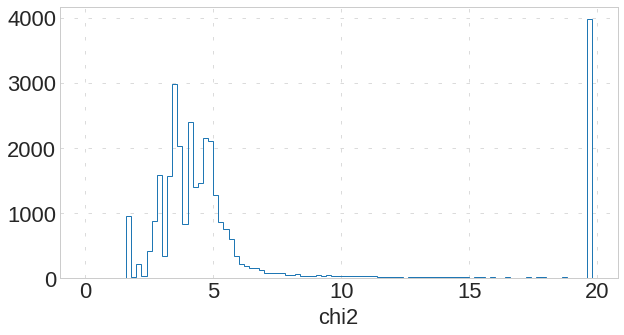

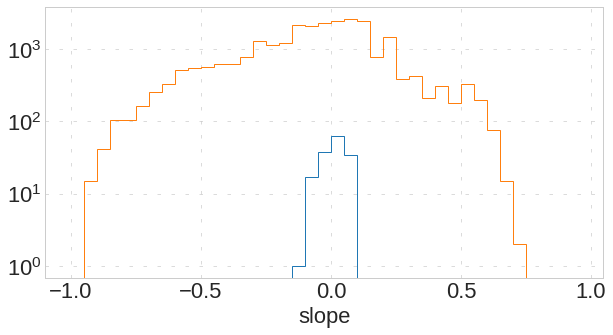

In [17]:
bins = np.arange(0,20,0.2)
plt.hist(np.clip(df_filt['redchi'], bins[0], bins[-1]) , bins=bins, histtype='step')
plt.xlabel('chi2');
plt.figure()
bins = np.arange(-1,1,0.05)
plt.hist(np.clip(df_failed.query('redchi<10')['slope'], bins[0], bins[-1]) , bins=bins, histtype='step');
plt.hist(np.clip(df_filt.query('redchi<10')['slope'], bins[0], bins[-1]) , bins=bins, histtype='step');
plt.yscale('log')
plt.xlabel('slope');

(0.1, 34581.29846212378)

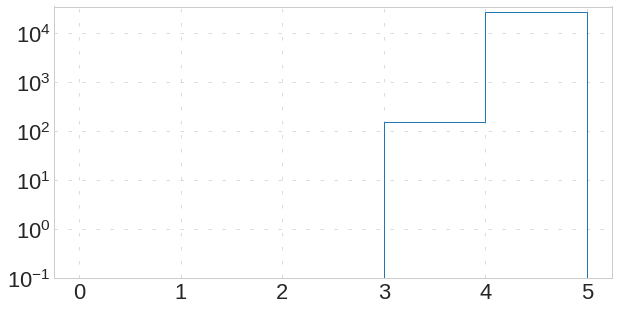

In [18]:
plt.hist(df_filt.query('redchi<10')['test_nhits'], range=(0,5), bins=5, histtype='step')
plt.yscale('log')
plt.ylim(0.1)
#df_filt.query('redchi<10')['test_nhits']

In [19]:
for layer in range(0,4):
  eff_ = df_filt.query('redchi<10')[testing_cols[layer]].gt(10).sum()/len(df_filt.query('redchi<10'))
  ineff_pred=4*math.pow(eff_, 3)-3*math.pow(eff_, 4)
  print("Efficiency: %.4f, 3/4 inefficiency: %.4e"%(eff_, 1-ineff_pred))

  eff_ = df_filt.query('redchi<10000000')[testing_cols[layer]].gt(10).sum()/len(df_filt.query('redchi<10000000')) 
  ineff_pred=4*math.pow(eff_, 3)-3*math.pow(eff_, 4)
  print("Efficiency: %.4f, 3/4 inefficiency: %.4e"%(eff_, 1-ineff_pred))
  print("----")

Efficiency: 0.9983, 3/4 inefficiency: 1.7548e-05
Efficiency: 0.9984, 3/4 inefficiency: 1.4923e-05
----
Efficiency: 0.9986, 3/4 inefficiency: 1.1358e-05
Efficiency: 0.9985, 3/4 inefficiency: 1.3188e-05
----
Efficiency: 0.9990, 3/4 inefficiency: 6.5077e-06
Efficiency: 0.9990, 3/4 inefficiency: 6.5051e-06
----
Efficiency: 0.9984, 3/4 inefficiency: 1.4632e-05
Efficiency: 0.9983, 3/4 inefficiency: 1.7403e-05
----


In [20]:
df_eff = pd.DataFrame(columns=['eff_layer0', 'eff_layer1', 'eff_layer2', 'eff_layer3', 'eff_layer_ave', 'events', 'thresh', 'nfold', 'ineff_obs', 'ineff_exp'])
j=0
for i in range(2,5):
  for thr in np.linspace(10,130,13):
    df_filt['test_nhits_'] = df_filt[testing_cols].gt(thr).sum(axis=1)


    row = np.array([])

    for layer in range(0,4):
      eff_ = df_filt.query('redchi<10')[testing_cols[layer]].gt(thr).sum()/len(df_filt.query('redchi<10')) 
      row = np.append(row, eff_)

    eff_layer_ave = np.average(row)
    neve = len(df_filt.query('redchi<10 & test_nhits_>=%d'%i))
    eff = neve/len(df_filt.query('redchi<10'))

    ineff_pred=-1
    if i==2:
      ineff_pred=6*math.pow(eff_layer_ave, 2)-8*math.pow(eff_layer_ave, 3)+3*math.pow(eff_layer_ave, 4)
    elif i==3:
      ineff_pred=4*math.pow(eff_layer_ave, 3)-3*math.pow(eff_layer_ave, 4)
    elif i==4:
      ineff_pred=math.pow(eff_layer_ave, 4)
    else:
      ineff_pred=0

    a = np.array([eff_layer_ave, neve, thr, i, 1-eff, 1-ineff_pred])
    row = np.concatenate((row, a))
    df_eff.loc[j] = row
    j=j+1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Text(0, 0.5, 'Single layer efficiency')

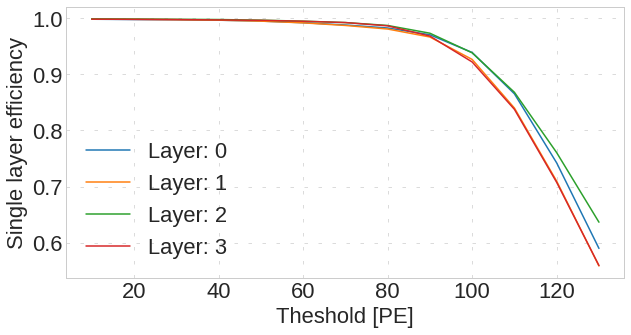

In [21]:
for layer in range(0,4):
  plt.plot(df_eff.query('nfold==%d'%3)['thresh'], df_eff.query('nfold==%d'%3)['eff_layer%d'%layer], '-', label='Layer: %d'%layer)
plt.legend()
plt.xlabel('Theshold [PE]')
plt.ylabel('Single layer efficiency')

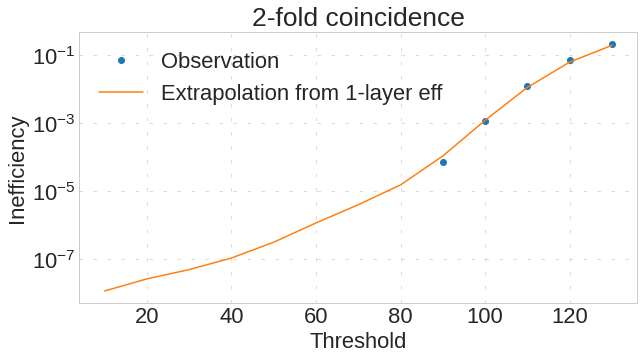

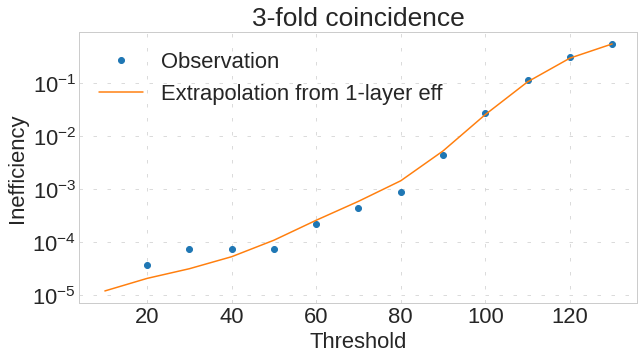

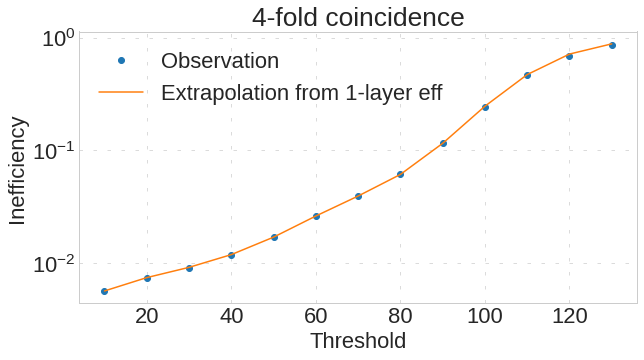

In [22]:
for nfold in [2,3,4]:
  plt.figure()
  plt.plot(df_eff.query('nfold==%d'%nfold)['thresh'], df_eff.query('nfold==%d'%nfold)['ineff_obs'], 'o', label='Observation')
  plt.plot(df_eff.query('nfold==%d'%nfold)['thresh'], df_eff.query('nfold==%d'%nfold)['ineff_exp'], '-', label='Extrapolation from 1-layer eff')
  plt.xlabel('Threshold')
  plt.ylabel('Inefficiency')
  plt.yscale('log')
  plt.title('%d-fold coincidence'%nfold)
  plt.legend()
#plt.ylim(1E-3,1.1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


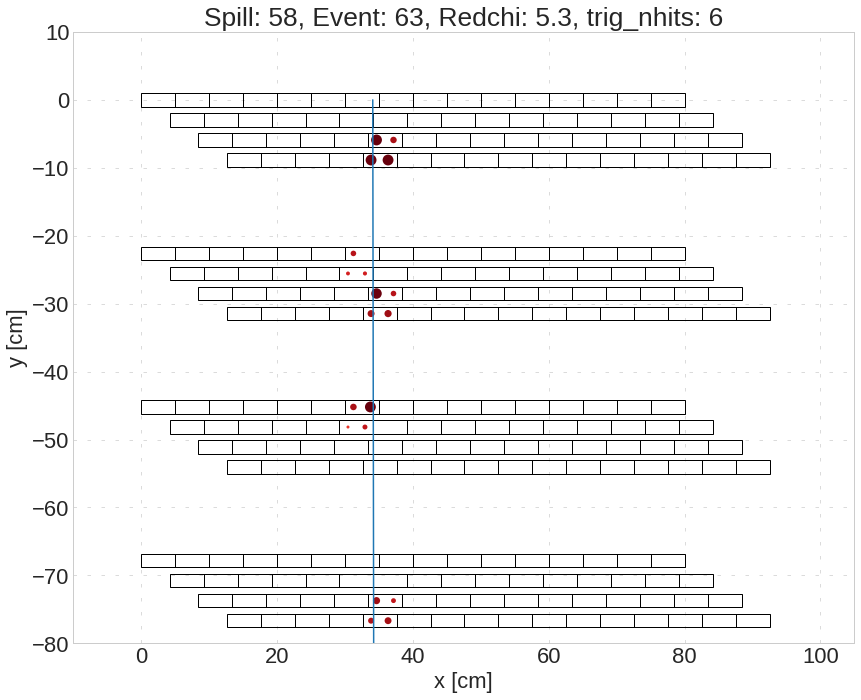

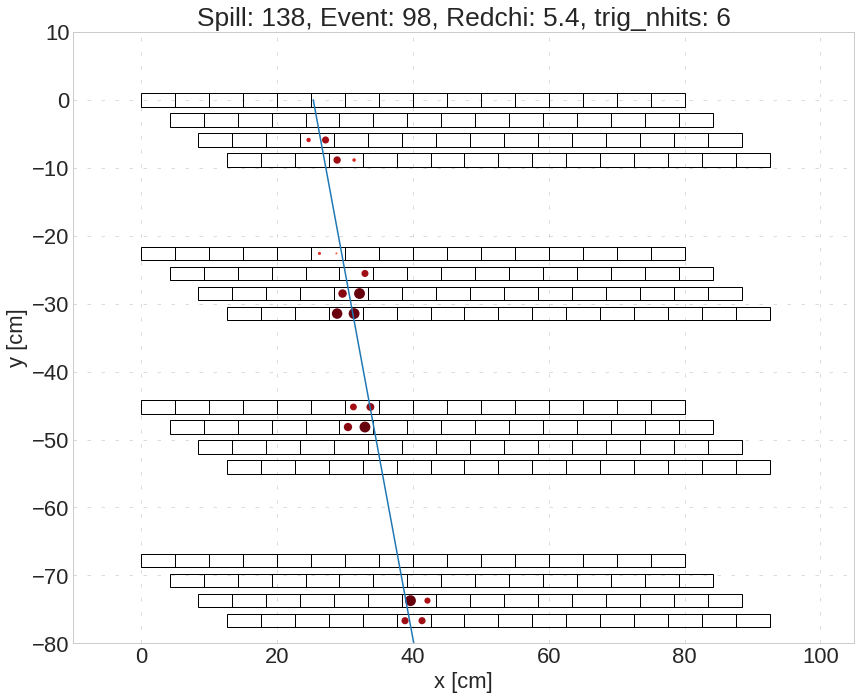

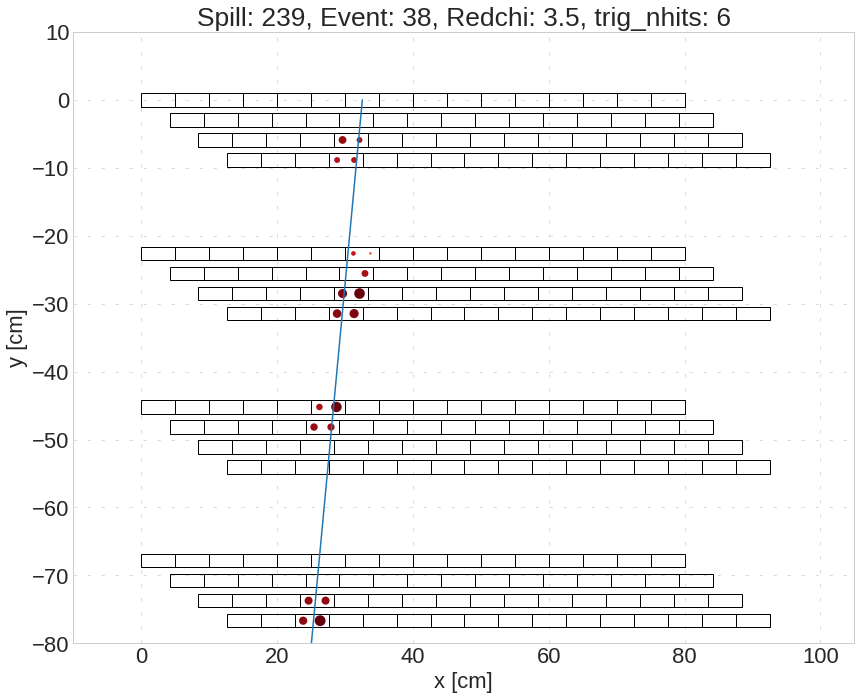

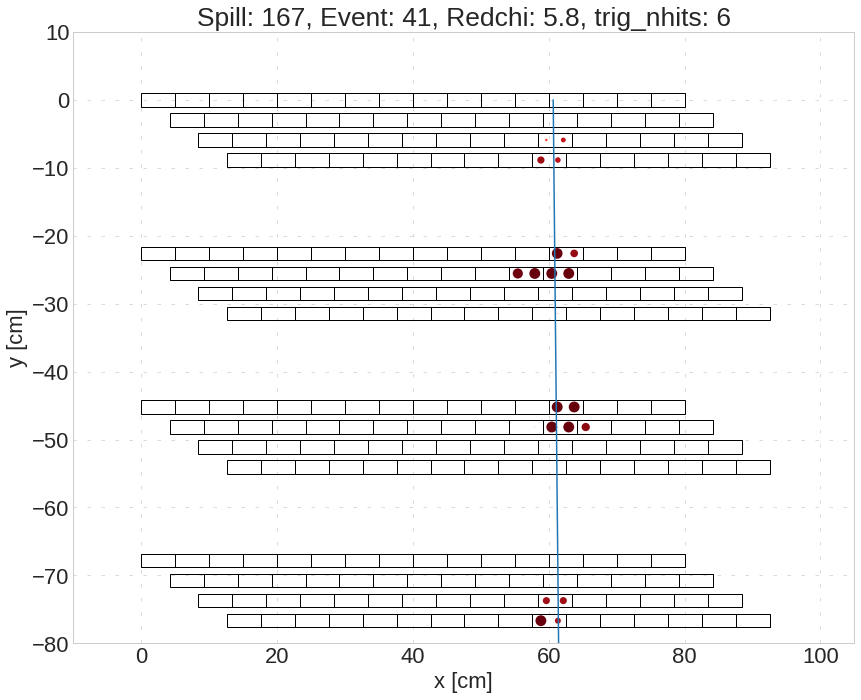

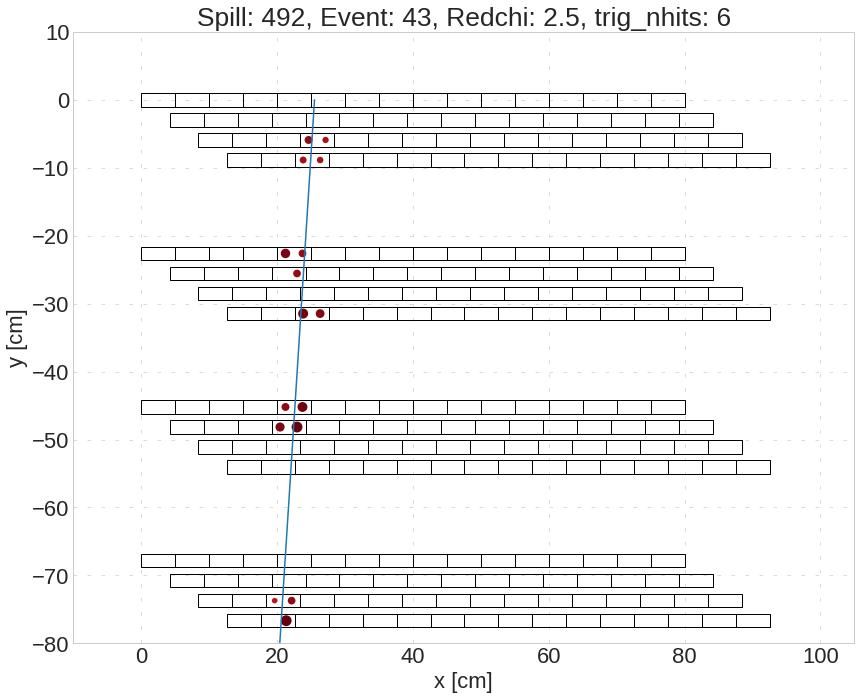

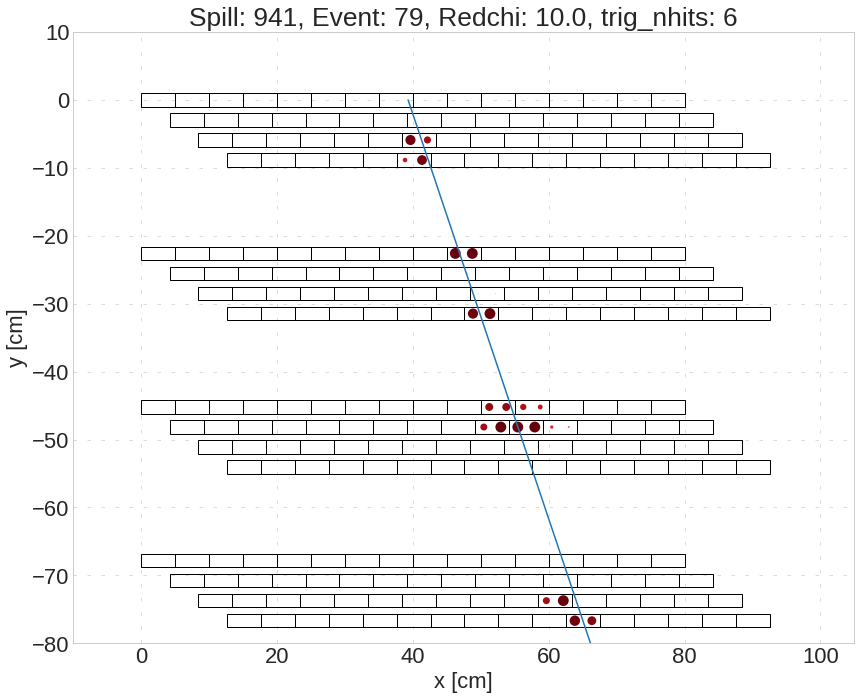

In [36]:
thresh = 60
df_filt['test_nhits'] = df_filt[testing_cols].gt(thresh).sum(axis=1)
df_failed = df_filt.query('test_nhits<3 & redchi<10')
df_tmp = df_failed.query('redchi<10')

for row in df_tmp.head(20).itertuples():
    plot_event(df_tmp, row.spillNumber, row.eventNumber)
    plt.title('Spill: %d, Event: %d, Redchi: %.1f, trig_nhits: %d'%(row.spillNumber, row.eventNumber, row.redchi, row.trig_nhits))
    y = np.linspace(-80, 0, 100)
    plt.plot(row.intercept+y*row.slope, y)

In [34]:
df_failed.query('redchi<10')

,index,spillNumber,eventNumber,timeSinceSpill_0_0,timeSinceSpill_0_1,timeSinceSpill_0_2,timeSinceSpill_0_3,timeSinceSpill_0_4,timeSinceSpill_0_5,timeSinceSpill_0_6,timeSinceSpill_0_7,timeSinceSpill_0_8,timeSinceSpill_0_9,timeSinceSpill_0_10,timeSinceSpill_0_11,timeSinceSpill_0_12,timeSinceSpill_0_13,timeSinceSpill_0_14,timeSinceSpill_0_15,timeSinceSpill_0_16,timeSinceSpill_0_17,timeSinceSpill_0_18,timeSinceSpill_0_19,timeSinceSpill_0_20,timeSinceSpill_0_21,timeSinceSpill_0_22,timeSinceSpill_0_23,timeSinceSpill_0_24,timeSinceSpill_0_25,timeSinceSpill_0_26,timeSinceSpill_0_27,timeSinceSpill_0_28,timeSinceSpill_0_29,timeSinceSpill_0_30,timeSinceSpill_0_31,timeSinceSpill_0_32,timeSinceSpill_0_33,timeSinceSpill_0_34,timeSinceSpill_0_35,timeSinceSpill_0_36,timeSinceSpill_0_37,timeSinceSpill_0_38,timeSinceSpill_0_39,timeSinceSpill_0_40,timeSinceSpill_0_41,timeSinceSpill_0_42,timeSinceSpill_0_43,timeSinceSpill_0_44,timeSinceSpill_0_45,timeSinceSpill_0_46,timeSinceSpill_0_47,timeSinceSpill_0_48,timeSinceSpill_0_49,timeSinceSpill_0_50,timeSinceSpill_0_51,timeSinceSpill_0_52,timeSinceSpill_0_53,timeSinceSpill_0_54,timeSinceSpill_0_55,timeSinceSpill_0_56,timeSinceSpill_0_57,timeSinceSpill_0_58,timeSinceSpill_0_59,timeSinceSpill_0_60,timeSinceSpill_0_61,timeSinceSpill_0_62,timeSinceSpill_0_63,timeSinceSpill_1_0,timeSinceSpill_1_1,timeSinceSpill_1_2,timeSinceSpill_1_3,timeSinceSpill_1_4,timeSinceSpill_1_5,timeSinceSpill_1_6,timeSinceSpill_1_7,timeSinceSpill_1_8,timeSinceSpill_1_9,timeSinceSpill_1_10,timeSinceSpill_1_11,timeSinceSpill_1_12,timeSinceSpill_1_13,timeSinceSpill_1_14,timeSinceSpill_1_15,timeSinceSpill_1_16,timeSinceSpill_1_17,timeSinceSpill_1_18,timeSinceSpill_1_19,timeSinceSpill_1_20,timeSinceSpill_1_21,timeSinceSpill_1_22,timeSinceSpill_1_23,timeSinceSpill_1_24,timeSinceSpill_1_25,timeSinceSpill_1_26,timeSinceSpill_1_27,timeSinceSpill_1_28,timeSinceSpill_1_29,timeSinceSpill_1_30,timeSinceSpill_1_31,timeSinceSpill_1_32,timeSinceSpill_1_33,timeSinceSpill_1_34,timeSinceSpill_1_35,timeSinceSpill_1_36,timeSinceSpill_1_37,timeSinceSpill_1_38,timeSinceSpill_1_39,timeSinceSpill_1_40,timeSinceSpill_1_41,timeSinceSpill_1_42,timeSinceSpill_1_43,timeSinceSpill_1_44,timeSinceSpill_1_45,timeSinceSpill_1_46,timeSinceSpill_1_47,timeSinceSpill_1_48,timeSinceSpill_1_49,timeSinceSpill_1_50,timeSinceSpill_1_51,timeSinceSpill_1_52,timeSinceSpill_1_53,timeSinceSpill_1_54,timeSinceSpill_1_55,timeSinceSpill_1_56,timeSinceSpill_1_57,timeSinceSpill_1_58,timeSinceSpill_1_59,timeSinceSpill_1_60,timeSinceSpill_1_61,timeSinceSpill_1_62,timeSinceSpill_1_63,timeSinceSpill_2_0,timeSinceSpill_2_1,timeSinceSpill_2_2,timeSinceSpill_2_3,timeSinceSpill_2_4,timeSinceSpill_2_5,timeSinceSpill_2_6,timeSinceSpill_2_7,timeSinceSpill_2_8,timeSinceSpill_2_9,timeSinceSpill_2_10,timeSinceSpill_2_11,timeSinceSpill_2_12,timeSinceSpill_2_13,timeSinceSpill_2_14,timeSinceSpill_2_15,timeSinceSpill_2_16,timeSinceSpill_2_17,timeSinceSpill_2_18,timeSinceSpill_2_19,timeSinceSpill_2_20,timeSinceSpill_2_21,timeSinceSpill_2_22,timeSinceSpill_2_23,timeSinceSpill_2_24,timeSinceSpill_2_25,timeSinceSpill_2_26,timeSinceSpill_2_27,timeSinceSpill_2_28,timeSinceSpill_2_29,timeSinceSpill_2_30,timeSinceSpill_2_31,timeSinceSpill_2_32,timeSinceSpill_2_33,timeSinceSpill_2_34,timeSinceSpill_2_35,timeSinceSpill_2_36,timeSinceSpill_2_37,timeSinceSpill_2_38,timeSinceSpill_2_39,timeSinceSpill_2_40,timeSinceSpill_2_41,timeSinceSpill_2_42,timeSinceSpill_2_43,timeSinceSpill_2_44,timeSinceSpill_2_45,timeSinceSpill_2_46,timeSinceSpill_2_47,timeSinceSpill_2_48,timeSinceSpill_2_49,timeSinceSpill_2_50,timeSinceSpill_2_51,timeSinceSpill_2_52,timeSinceSpill_2_53,timeSinceSpill_2_54,timeSinceSpill_2_55,timeSinceSpill_2_56,timeSinceSpill_2_57,timeSinceSpill_2_58,timeSinceSpill_2_59,timeSinceSpill_2_60,timeSinceSpill_2_61,timeSinceSpill_2_62,timeSinceSpill_2_63,timeSinceSpill_3_0,timeSinceSpill_3_1,timeSinceSpill_3_2,timeSinceSpill_3_3,timeSinceSpill_3_4,timeSinceSpill_3_5,timeSinceSpill_3_6,timeSinceSpill_3_7,timeSin